# 01. Perform simulations

In [1]:
import simserialED.core as simserialED
from orix.crystal_map import Phase
from orix.sampling import get_sample_reduced_fundamental, get_sample_fundamental
from diffsims.generators.simulation_generator import SimulationGenerator
from diffpy.structure import Atom, Lattice, Structure
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor

In [3]:
# Read the PDB file into an ASE Atoms object
atoms = read("/Users/xiaodong/Desktop/UOXsim/UOX.pdb")

# Convert the ASE Atoms object to a pymatgen Structure
structure = AseAtomsAdaptor.get_structure(atoms)

# Build a list of diffpy Atom objects
atoms_diffpy = []
# We convert fractional coordinates to Cartesian coordinates
for site in structure.sites:
    # Create the Atom; note that site.species_string gives a string for the species
    atoms_diffpy.append(Atom(site.species_string))

print(atoms_diffpy)


[N    0.000000 0.000000 0.000000 1.0000, C    0.000000 0.000000 0.000000 1.0000, C    0.000000 0.000000 0.000000 1.0000, O    0.000000 0.000000 0.000000 1.0000, C    0.000000 0.000000 0.000000 1.0000, O    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, C    0.000000 0.000000 0.000000 1.0000, C    0.000000 0.000000 0.000000 1.0000, O    0.000000 0.000000 0.000000 1.0000, C    0.000000 0.000000 0.000000 1.0000, O    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000, H    0.000000 0.000000 0.000000 1.0000,

100%|██████████| 171/171 [00:11<00:00, 14.96it/s]


"A quick-plot function for a simulation of spots\n\nParameters\n----------\nsize_factor : float, optional\n    linear spot size scaling, default to 1\ndirect_beam_position: 2-tuple of ints, optional\n    The (x,y) coordinate in pixels of the direct beam. Defaults to\n    the center of the image.\nin_plane_angle: float, optional\n    In plane rotation of the pattern in degrees\nmirrored: bool, optional\n    Whether the pattern should be flipped over the x-axis,\n    corresponding to the inverted orientation\nunits : str, optional\n    'real' or 'pixel', only changes scalebars, falls back on 'real', the default\nshow_labels : bool, optional\n    draw the miller indices near the spots\nlabel_offset : 2-tuple, optional\n    the relative location of the spot labels. Does nothing if `show_labels`\n    is False.\nlabel_formatting : dict, optional\n    keyword arguments passed to `ax.text` for drawing the labels. Does\n    nothing if `show_labels` is False.\nmin_label_intensity : float, option

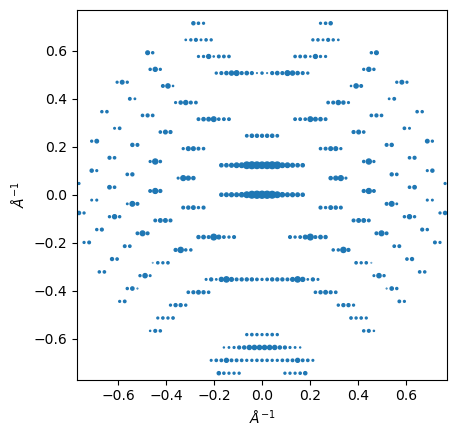

In [7]:

a = 80.58 
b = 94.49 
c = 103.89 
al = 90.00 
be = 90.00 
ga = 90.00 

lattice = Lattice(a, b, c, al, be, ga)

# Create the structure and corresponding phase
structure = Structure(atoms_diffpy, lattice)
phase = Phase(space_group=23, structure=structure)

# Sample orientations in the symmetry-reduced zone (resolution in degrees)
orientations = get_sample_reduced_fundamental(
    resolution=10,
    point_group=phase.point_group,
)

# Initialize the simulation generator (e.g., setting the accelerating voltage)
generator = SimulationGenerator(
        accelerating_voltage = 300, #default 200
        scattering_params = "lobato",
        precession_angle = 0,
        shape_factor_model = "sinc",
        approximate_precession = False,
        minimum_intensity = 1e-20,
        )

"""
Parameters
----------
accelerating_voltage
    The accelerating voltage of the electrons in keV.
scattering_params
    The scattering parameters to use. One of 'lobato', 'xtables'
precession_angle
    The precession angle in degrees. If 0, no precession is applied.
shape_factor_model
    The shape factor model to use. One of 'linear', 'atanc', 'sinc', 'sin2c', 'lorentzian'
approximate_precession
    If True, the precession is approximated by a Lorentzian function.
minimum_intensity
    The minimum intensity of a reflection to be included in the profile.
kwargs
    Keyword arguments to pass to the shape factor model.

"""

# Calculate 2D diffraction simulations using the provided phase and orientations
simulations = generator.calculate_diffraction2d(
    phase = phase,
    rotation = orientations,
    reciprocal_radius = 1/1.3,  # 1/Å (i.e. Å⁻¹)
    with_direct_beam = True,   # Include the direct beam
    max_excitation_error = 0.0003,
    shape_factor_width = None,
    debye_waller_factors = None,
    show_progressbar = True
)

"""Calculates the diffraction pattern for one or more phases given a list
of rotations for each phase.

Parameters
----------
phase:
    The phase(s) for which to derive the diffraction pattern.
reciprocal_radius
    The maximum radius of the sphere of reciprocal space to
    sample, in reciprocal Angstroms.
rotation
    The Rotation object(s) to apply to the structure and then
    calculate the diffraction pattern.
with_direct_beam
    If True, the direct beam is included in the simulated
    diffraction pattern. If False, it is not.
max_excitation_error
    The cut-off for geometric excitation error in the z-direction
    in units of reciprocal Angstroms. Spots with a larger distance
    from the Ewald sphere are removed from the pattern.
    Related to the extinction distance and roughly equal to 1/thickness.
shape_factor_width
    Determines the width of the reciprocal rel-rod, for fine-grained
    control. If not set will be set equal to max_excitation_error.
debye_waller_factors
    Maps element names to their temperature-dependent Debye-Waller factors.
show_progressbar
    If True, display a progressbar. Defaults to False
    """

# Plot the simulations (this may include an interactive slider)
simulations.plot(
        size_factor=1,
        direct_beam_position=None,
        in_plane_angle=0,
        mirrored=False,
        units="real",
        show_labels=False,
        label_offset=(0, 0),
        label_formatting=None,
        min_label_intensity=0.1,
        include_direct_beam=True,
        calibration = 0.0015090274190359715,
        ax=None,
        interactive=False,
    )

"""A quick-plot function for a simulation of spots

Parameters
----------
size_factor : float, optional
    linear spot size scaling, default to 1
direct_beam_position: 2-tuple of ints, optional
    The (x,y) coordinate in pixels of the direct beam. Defaults to
    the center of the image.
in_plane_angle: float, optional
    In plane rotation of the pattern in degrees
mirrored: bool, optional
    Whether the pattern should be flipped over the x-axis,
    corresponding to the inverted orientation
units : str, optional
    'real' or 'pixel', only changes scalebars, falls back on 'real', the default
show_labels : bool, optional
    draw the miller indices near the spots
label_offset : 2-tuple, optional
    the relative location of the spot labels. Does nothing if `show_labels`
    is False.
label_formatting : dict, optional
    keyword arguments passed to `ax.text` for drawing the labels. Does
    nothing if `show_labels` is False.
min_label_intensity : float, optional
    minimum intensity for a spot to be labelled
include_direct_beam : bool, optional
    whether to include the direct beam in the plot
ax : matplotlib Axes, optional
    axes on which to draw the pattern. If `None`, a new axis is created
interactive : bool, optional
    Whether to add sliders for selecting the rotation and phase. This
    is an experimental feature and will evolve/change in the future.
"""


# 02. Add simulations to dataset

In [5]:
import shutil
import h5py
import random
from tqdm import tqdm

# Input (original) file
input_filename = "/Users/xiaodong/Desktop/UOXs-2/UOXs_radial_backgrounds.h5"

# Output (copy) file
output_filename = "/Users/xiaodong/Desktop/UOXsim/UOXsim.h5"

# Make an identical copy of the original file
shutil.copyfile(input_filename, output_filename)

# Open the copy in read/write mode so that you can modify it safely
with h5py.File(output_filename, "r+") as data:
    images = data["entry"]["data"]["images"]

    # Create (or open if they already exist) a dataset to store simulation Euler angles.
    euler_angles = data["entry"]["data"].require_dataset(
        "simulation_euler_angles", 
        shape=(images.shape[0], 3), 
        dtype=float
    )

    # Get the image shape (assumes the last two dimensions hold the 2D image)
    shape = images.shape[-2:]
    calibration = 0.0015090274190359715 # calibration: 1/Å per pixel
    intensity_scale = 1000

    # Loop over each image using a progress bar
    for i in tqdm(range(images.shape[0]), desc="Processing images"):
        # Choose a random in-plane rotation angle (in degrees)
        in_plane = random.uniform(0, 360)

        # Choose a random simulation index
        ind = random.randint(0, simulations.current_size - 1)

        # Generate simulation diffraction image using the chosen simulation and rotation
        img = simulations.irot[ind].get_diffraction_pattern(
            shape=shape,
            direct_beam_position=(shape[0] // 2, shape[1] // 2),  # pixel coordinates of the direct beam
            sigma=1,
            in_plane_angle=in_plane,
            calibration=calibration,
            fast=False,
            normalize = True,
            fast_clip_threshold = 0.1,
        )
        # /diffsims/simulations/simulation2d.py
        """
        shape  : tuple of ints
            The size of a side length (in pixels)
        sigma : float
            Standard deviation of the Gaussian function to be plotted (in pixels).
        direct_beam_position: 2-tuple of ints, optional
            The (x,y) coordinate in pixels of the direct beam. Defaults to
            the center of the image.
        in_plane_angle: float, optional
            In plane rotation of the pattern in degrees
        mirrored: bool, optional
            Whether the pattern should be flipped over the x-axis,
            corresponding to the inverted orientation
        fast: bool, optional
            Whether to speed up calculations by rounding spot coordinates down to integer pixel
        normalize: bool, optional
            Whether to normalize the pattern to values between 0 and 1
        fast_clip_threshold: float, optional
            Only used when `fast` is False.
            Pixel intensity threshold, such that pixels which would be below this value are ignored.
            Thresholding performed before possible normalization.
            See diffsims.pattern.detector_functions.get_pattern_from_pixel_coordinates_and_intensities for details.
        Returns
        """
        # Scale image intensity to match the original image's data type
        img = (img * intensity_scale).astype(images.dtype)

        # Option A: Directly add the simulation to the existing "images" dataset
        images[i] += img


        # Retrieve and adjust Euler angles from the simulation
        euler_angles_i = simulations.rotations[ind].to_euler(degrees=True).squeeze()
        euler_angles_i[0] = in_plane  # Override the first angle with the random in-plane rotation
        euler_angles[i] = euler_angles_i

print("Done! The combined file is saved at:", output_filename)



Processing images: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]

Done! The combined file is saved at: /Users/xiaodong/Desktop/UOXsim/UOXsim.h5


# 03. Visualize simulations

In [6]:
# Make sure your notebook uses an interactive backend.
# For inline static images, you can use:
%matplotlib inline
# For interactive figures, you can also try:
# %matplotlib widget

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

# Open the file and preload the datasets into memory.
filename = "/Users/xiaodong/Desktop/UOXsim/UOXsim.h5"
with h5py.File(filename, "r") as hf:
    images = hf["entry"]["data"]["images"]
    euler_angles = hf["entry"]["data"]["simulation_euler_angles"]
    
    # Optional: print shapes for debugging
    # print("Images shape:", images.shape)
    # print("Euler angles shape:", euler_angles.shape)
    
    # Preload the data (this works well if the datasets aren't too large)
    images_arr = images[:]       # All images as a NumPy array.
    angles_arr = euler_angles[:]   # All Euler angles.

def view_image(index):
    # Clear the previous output for a smoother experience.
    clear_output(wait=True)
    
    # Retrieve the image and Euler angles for the selected index.
    img = images_arr[index]
    angles = angles_arr[index]
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap="gray")
    plt.title(f"Image Index: {index}\nEuler Angles: {angles}")
    plt.axis("off")
    plt.show()

# Create an interactive slider.
interact(view_image, index=widgets.IntSlider(min=0, max=images_arr.shape[0]-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='index', max=99), Output()), _dom_classes=('widget-intera…

<function __main__.view_image(index)>